<a href="https://colab.research.google.com/github/yenirsmwati/Stacking-Ensemble-/blob/main/Classification_of_COVID_19_with_SMOTE_Oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'symptoms-and-covid-presence:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F836054%2F1427628%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240728%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240728T020246Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c0344d8497850a2251874f49b31f8a8e402c87067e5c828e188eb597a2ff18d6582d8cb4cbafe9542488f91d9492dc868f2098c7db18906a196e66cbeb084f1c4762afcc7aab1bd91d81099488fa0a8b13fabc6a9e24b39cbbd65f307a2d36d2ab36f2387afd246425752d371708898eb49e947cdd60bdd2899ba8df547299ea818cb96abdad34cebcef388f485cdb27a5e064b24612fc69f437ab06a949cc677fb912a6208109d6b7f1d8d30052f46d419d908407299036ec4ef147de709306ef9b04ccf1ad461a26bd324921994576605b0eebfba0a82d7ef68dee452ffa00956311a6cfeb34cf368530f63bc568fd57b4e8b202e519cc8f9025f75ee27fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26431 bytes downloaded
Downloaded and uncompressed: symptoms-and-covid-presence
Data source import complete.


In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data preparation

In [62]:
data_covid=pd.read_csv("/kaggle/input/symptoms-and-covid-presence/Covid Dataset.csv")
data_covid.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,...,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,...,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,...,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,...,No,Yes,No,Yes,No,Yes,No,No,No,Yes


In [63]:
data_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Breathing Problem                        5434 non-null   object
 1   Fever                                    5434 non-null   object
 2   Dry Cough                                5434 non-null   object
 3   Sore throat                              5434 non-null   object
 4   Running Nose                             5434 non-null   object
 5   Asthma                                   5434 non-null   object
 6   Chronic Lung Disease                     5434 non-null   object
 7   Headache                                 5434 non-null   object
 8   Heart Disease                            5434 non-null   object
 9   Diabetes                                 5434 non-null   object
 10  Hyper Tension                            5434 non-null   obj

In [64]:
data_covid.dtypes

Breathing Problem                          object
Fever                                      object
Dry Cough                                  object
Sore throat                                object
Running Nose                               object
Asthma                                     object
Chronic Lung Disease                       object
Headache                                   object
Heart Disease                              object
Diabetes                                   object
Hyper Tension                              object
Fatigue                                    object
Gastrointestinal                           object
Abroad travel                              object
Contact with COVID Patient                 object
Attended Large Gathering                   object
Visited Public Exposed Places              object
Family working in Public Exposed Places    object
Wearing Masks                              object
Sanitization from Market                   object


In [65]:
unique_values = data_covid.apply(lambda col: col.unique())
print(unique_values)

Breathing Problem                          [Yes, No]
Fever                                      [Yes, No]
Dry Cough                                  [Yes, No]
Sore throat                                [Yes, No]
Running Nose                               [Yes, No]
Asthma                                     [No, Yes]
Chronic Lung Disease                       [No, Yes]
Headache                                   [No, Yes]
Heart Disease                              [No, Yes]
Diabetes                                   [Yes, No]
Hyper Tension                              [Yes, No]
Fatigue                                    [Yes, No]
Gastrointestinal                           [Yes, No]
Abroad travel                              [No, Yes]
Contact with COVID Patient                 [Yes, No]
Attended Large Gathering                   [No, Yes]
Visited Public Exposed Places              [Yes, No]
Family working in Public Exposed Places    [Yes, No]
Wearing Masks                                 

Because columns **Wearing Masks** and **Sanitization from Market** only have one value, the two columns will be dropped.

In [66]:
new_df = data_covid.drop(['Wearing Masks','Sanitization from Market'], axis = 1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Breathing Problem                        5434 non-null   object
 1   Fever                                    5434 non-null   object
 2   Dry Cough                                5434 non-null   object
 3   Sore throat                              5434 non-null   object
 4   Running Nose                             5434 non-null   object
 5   Asthma                                   5434 non-null   object
 6   Chronic Lung Disease                     5434 non-null   object
 7   Headache                                 5434 non-null   object
 8   Heart Disease                            5434 non-null   object
 9   Diabetes                                 5434 non-null   object
 10  Hyper Tension                            5434 non-null   obj

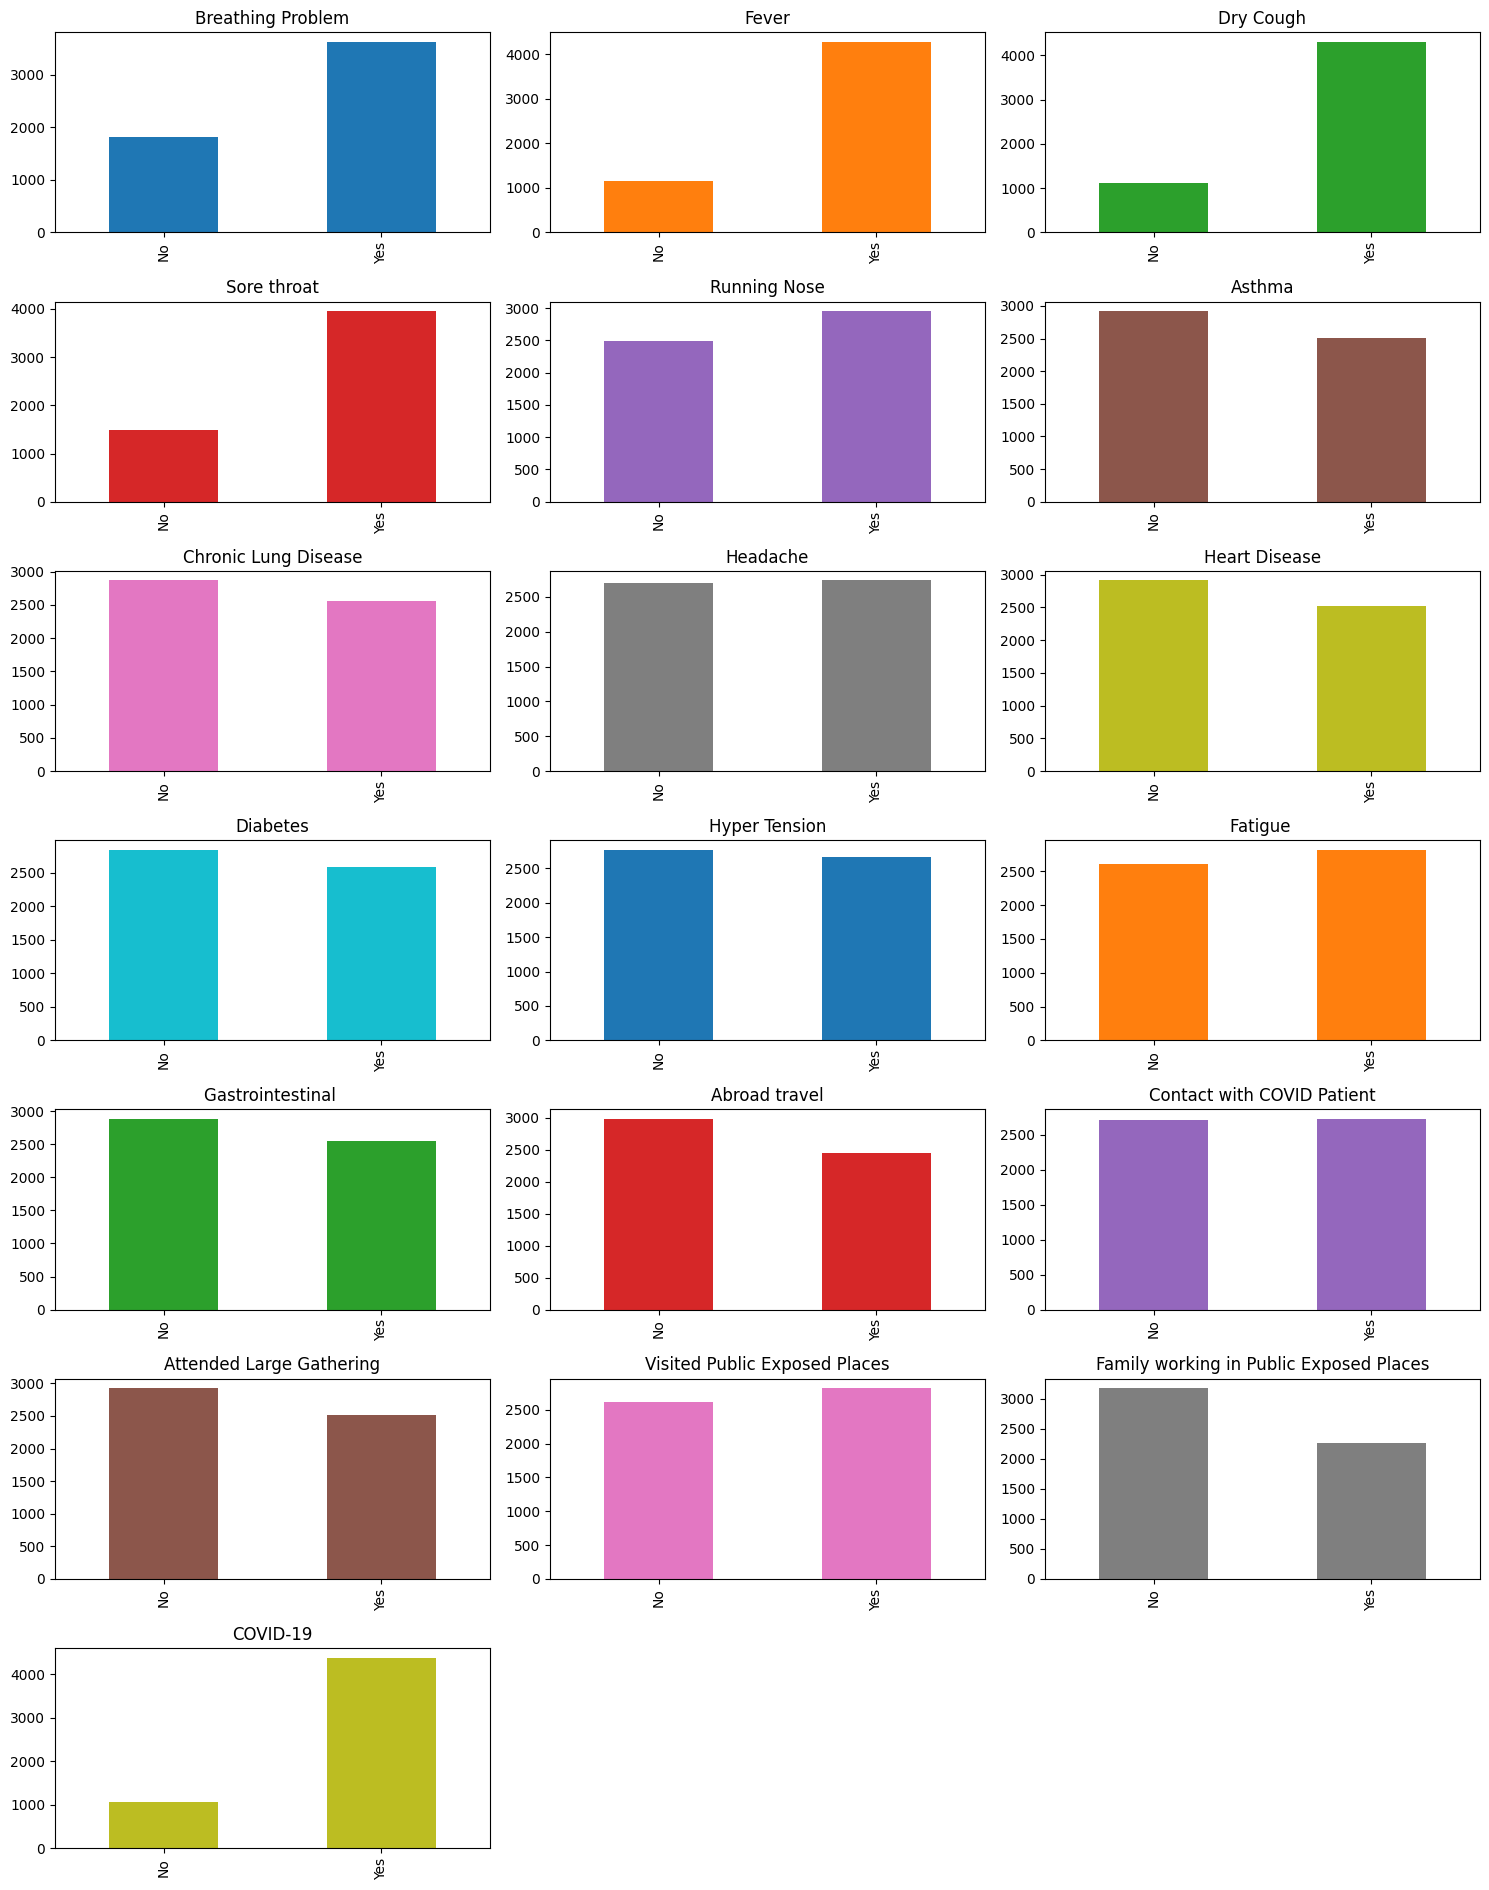

In [67]:
import matplotlib.pyplot as plt
new_df.apply(pd.Series.value_counts).plot(kind='bar', subplots=True, layout=(7, 3), figsize=(15, 19), legend=False, sharex=False, sharey=False)

plt.tight_layout()  #for the layout doesn't overlap
plt.show()

In [68]:
variables = new_df.columns[new_df.columns != 'COVID-19']
variables

Index(['Breathing Problem', 'Fever', 'Dry Cough', 'Sore throat',
       'Running Nose', 'Asthma', 'Chronic Lung Disease', 'Headache',
       'Heart Disease', 'Diabetes', 'Hyper Tension', 'Fatigue ',
       'Gastrointestinal ', 'Abroad travel', 'Contact with COVID Patient',
       'Attended Large Gathering', 'Visited Public Exposed Places',
       'Family working in Public Exposed Places'],
      dtype='object')

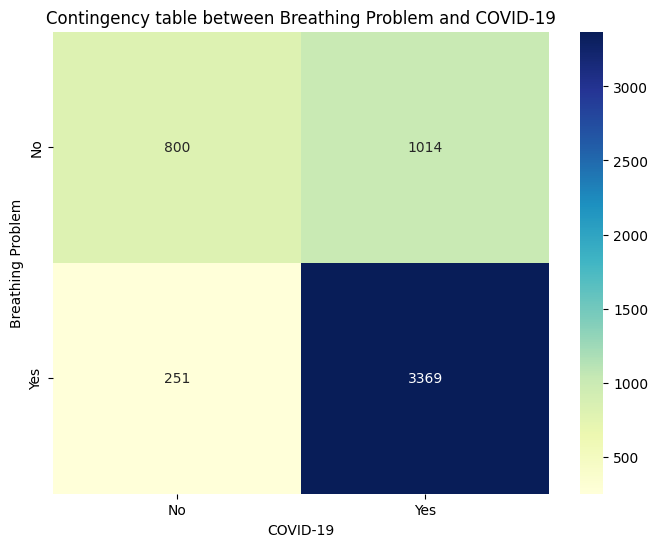

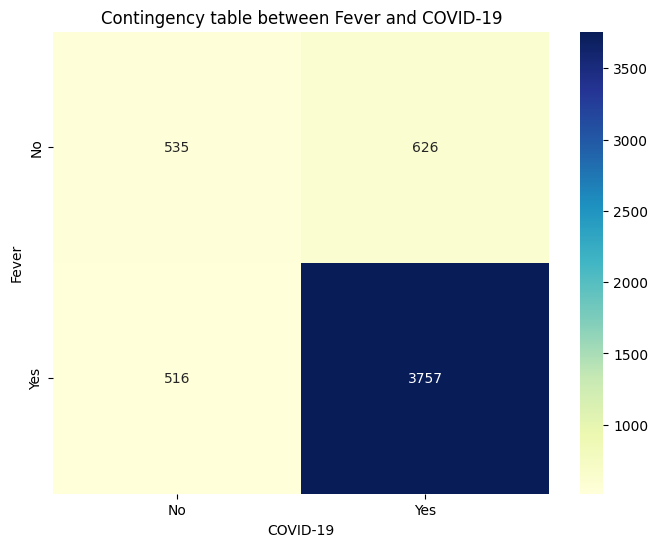

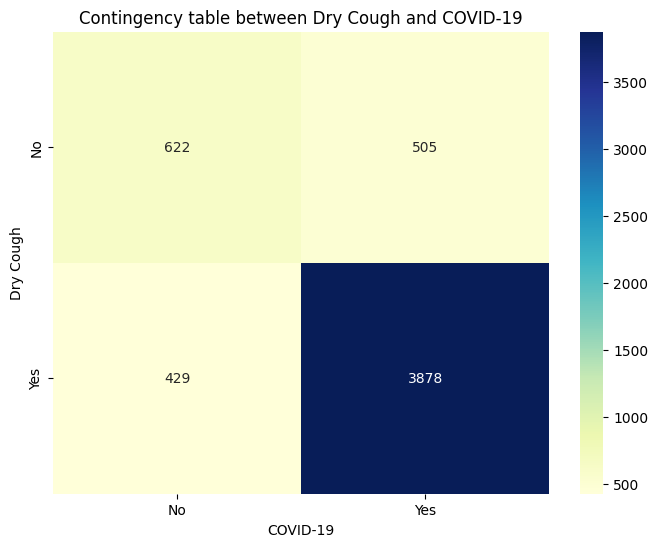

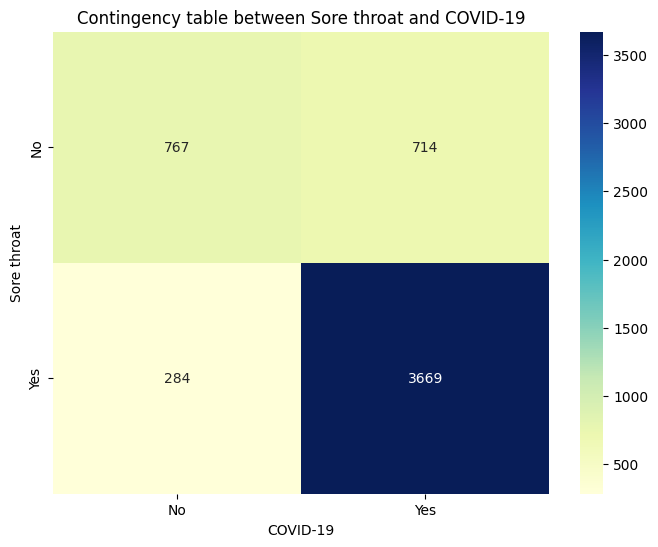

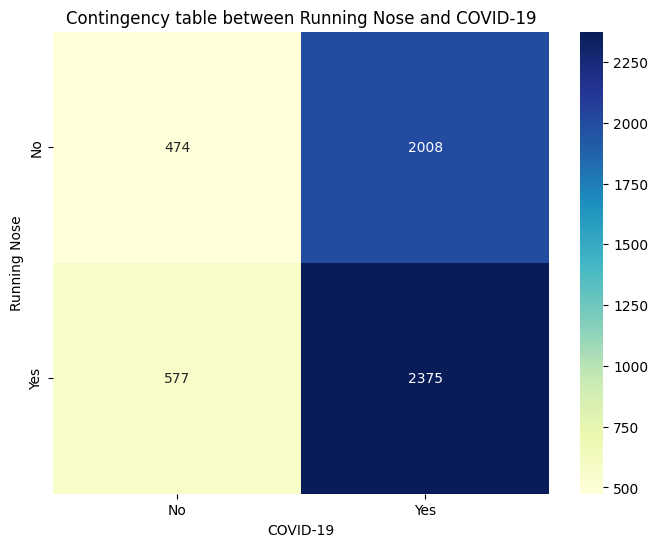

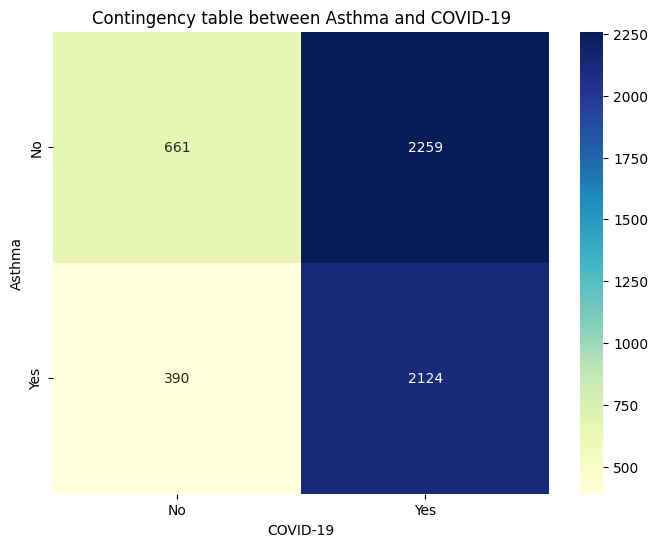

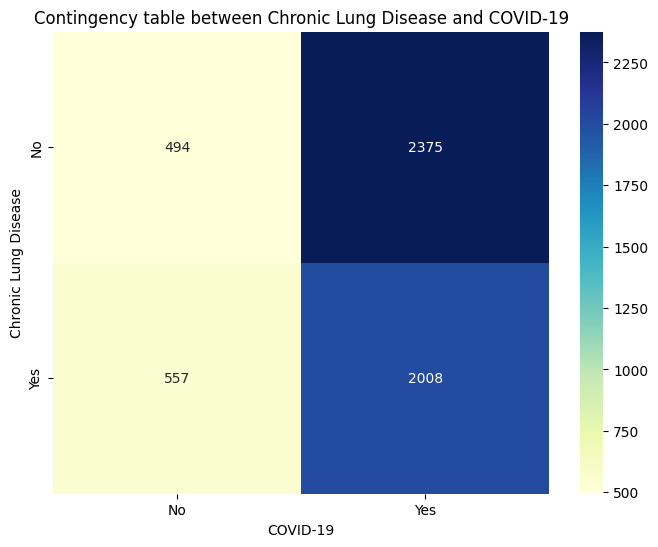

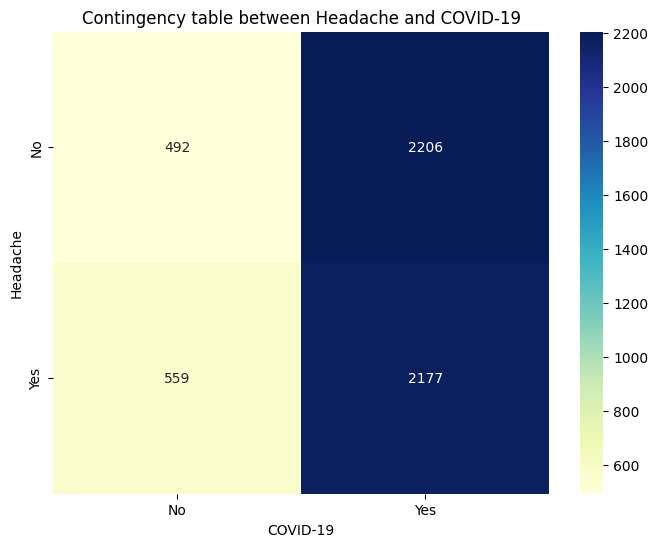

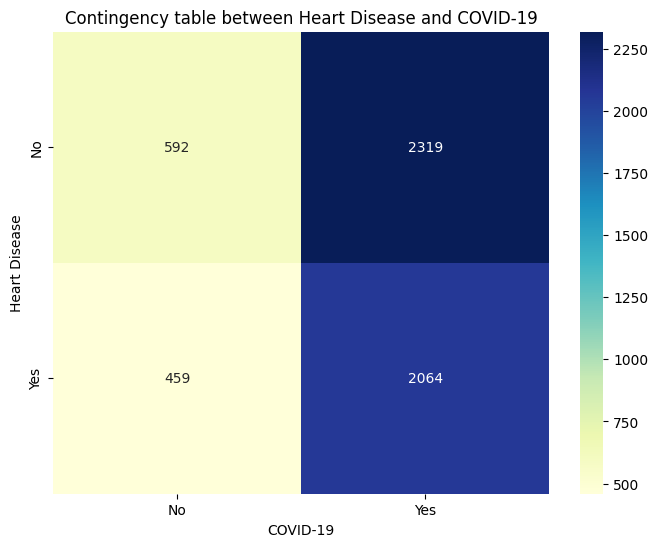

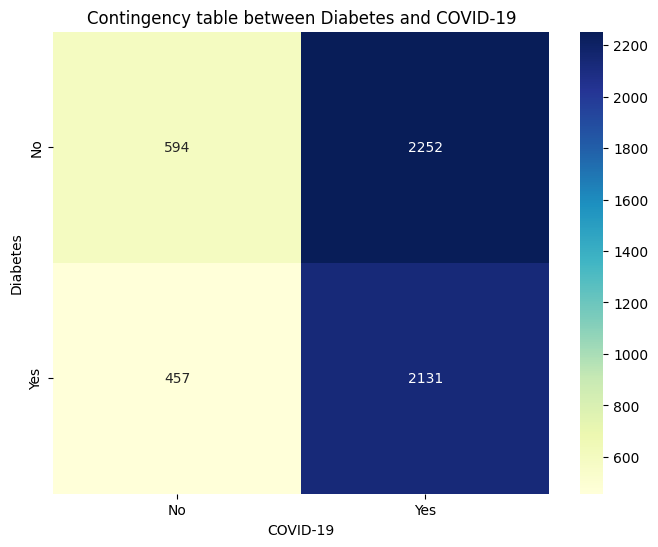

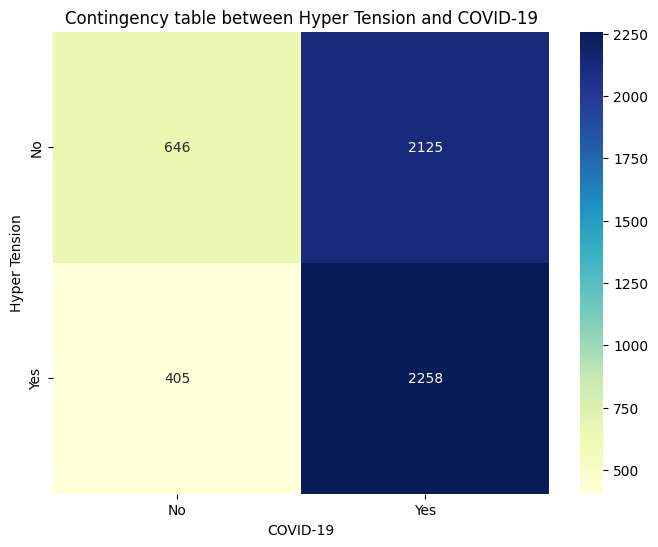

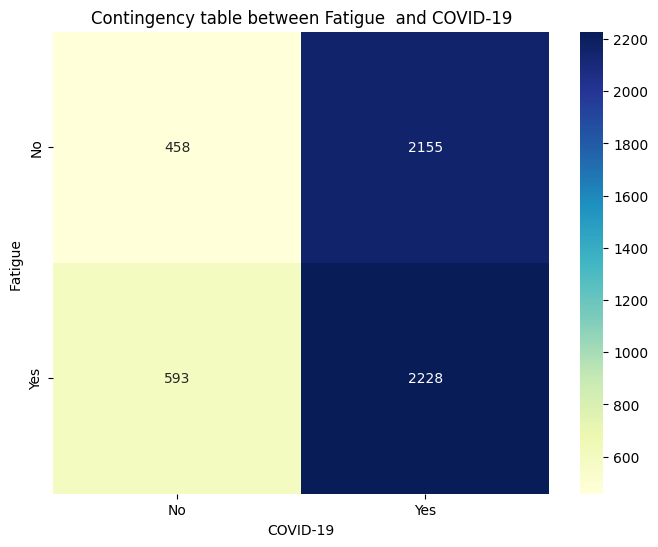

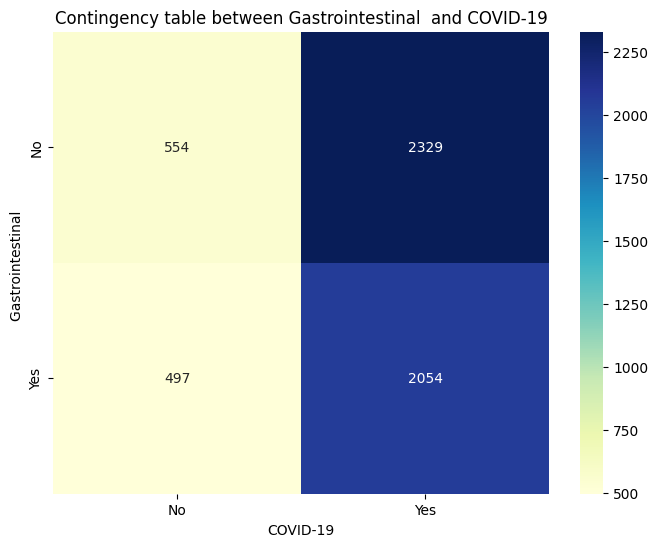

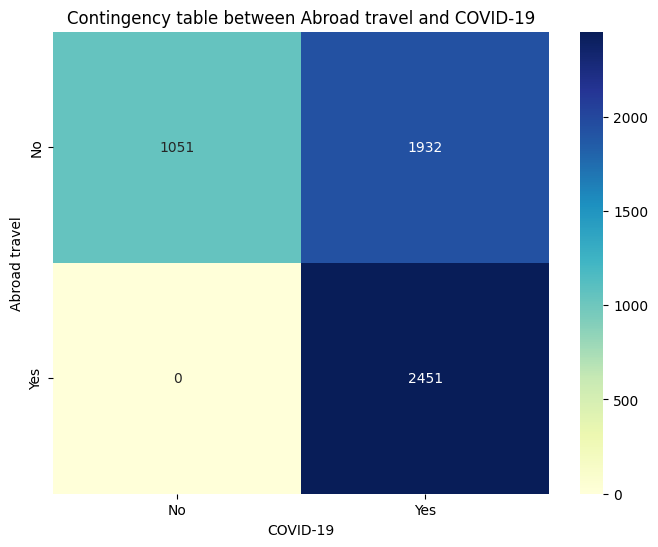

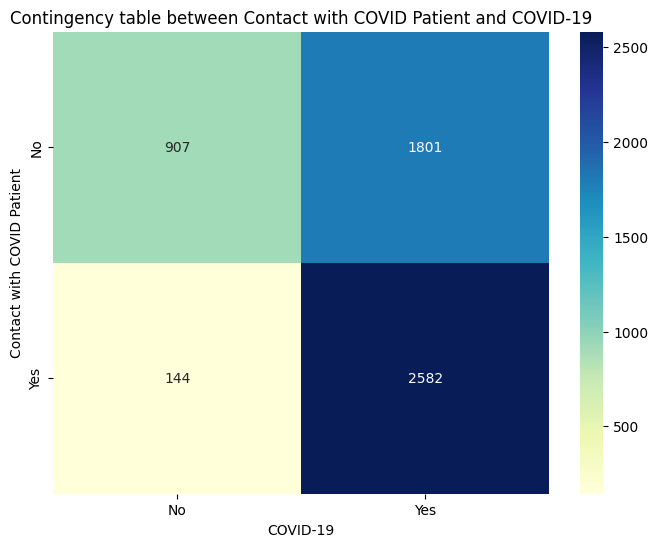

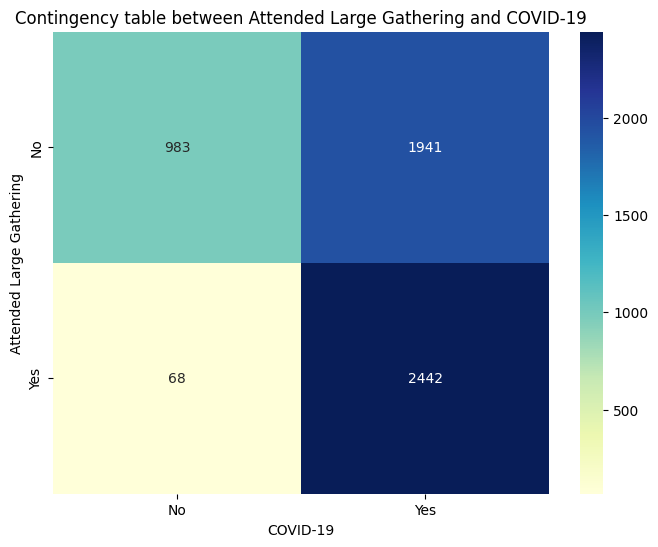

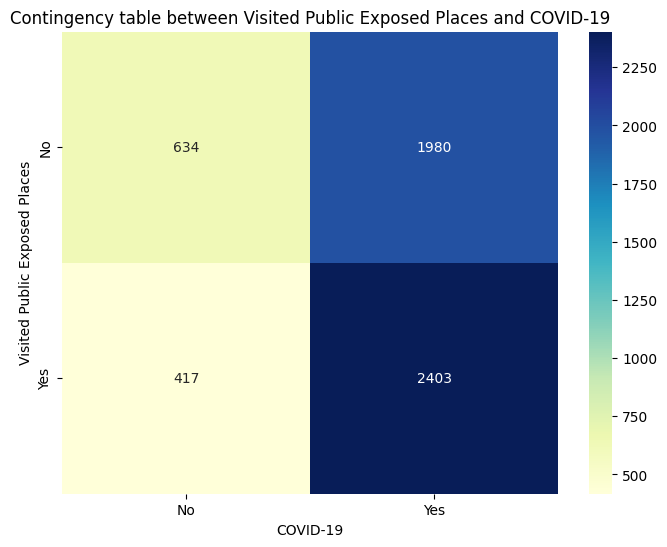

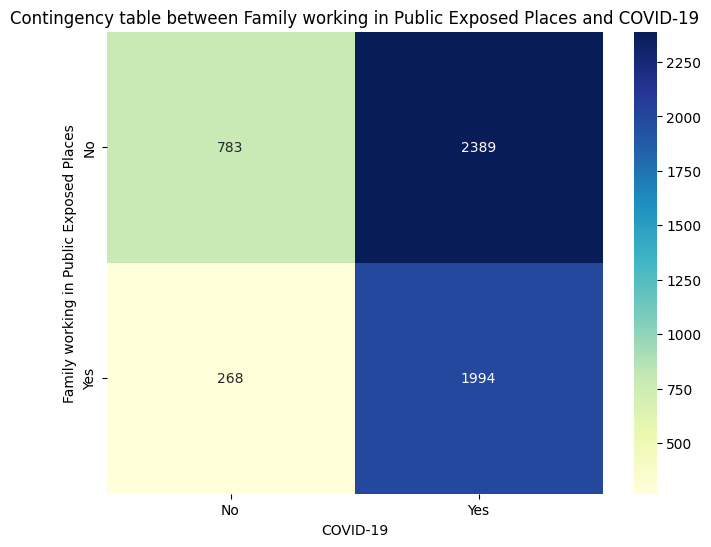

In [69]:
import seaborn as sns
for var in variables:
    table = pd.crosstab(new_df[var], new_df['COVID-19'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(table, annot=True, cmap='YlGnBu', fmt='d')
    plt.title(f'Contingency table between {var} and COVID-19')
    plt.show()

In [70]:
mapping = {'Yes': 1, 'No': 0}
df_numeric = new_df.replace(mapping)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Breathing Problem                        5434 non-null   int64
 1   Fever                                    5434 non-null   int64
 2   Dry Cough                                5434 non-null   int64
 3   Sore throat                              5434 non-null   int64
 4   Running Nose                             5434 non-null   int64
 5   Asthma                                   5434 non-null   int64
 6   Chronic Lung Disease                     5434 non-null   int64
 7   Headache                                 5434 non-null   int64
 8   Heart Disease                            5434 non-null   int64
 9   Diabetes                                 5434 non-null   int64
 10  Hyper Tension                            5434 non-null   int64
 11  Fati

In [71]:
df_numeric.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,COVID-19
0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,1
1,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,1
2,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1
3,1,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,1
4,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,1,0,1


In [72]:
Y = df_numeric['COVID-19']
X = df_numeric.drop(['COVID-19'], axis = 1)

In [73]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [74]:
X_train.shape[0]

4075

In [75]:
X_test.shape[0]

1359

In [76]:
Y_train.shape[0]

4075

In [77]:
Y_test.shape[0]

1359

In [78]:
y_train_counts = pd.Series(Y_train).value_counts()
y_train_counts

COVID-19
1    3299
0     776
Name: count, dtype: int64

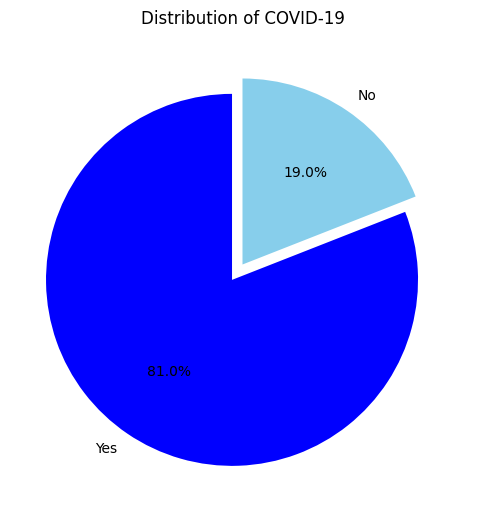

In [79]:
value_counts = Y_train.value_counts()

labels = {1: 'Yes', 0: 'No'}
labels_to_use = [labels[value] for value in value_counts.index]

plt.figure(figsize=(6,8))
plt.pie(value_counts,
        labels=labels_to_use,
        explode=(.1, 0),
        colors=['blue', 'skyblue'],
        autopct="%1.1f%%",
        startangle=90)
plt.title('Distribution of COVID-19')
plt.show()

The pie chart shows that the data train is imbalanced. To handle this, we will use oversampling with SMOTE to balance out the data.

# Oversampling with Smote

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

# Combine back into a new DataFrame
df_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
df_train_resampled['COVID-19'] = y_train_resampled
df_train_resampled

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,COVID-19
0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,0,0,1
2,1,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1
3,0,1,1,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0
4,0,1,1,1,0,0,0,0,1,0,0,1,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,0,1,0,1,0,1,1,1,0,1,0,0,1,0,0,0,1,1,0
6594,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
6595,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0
6596,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


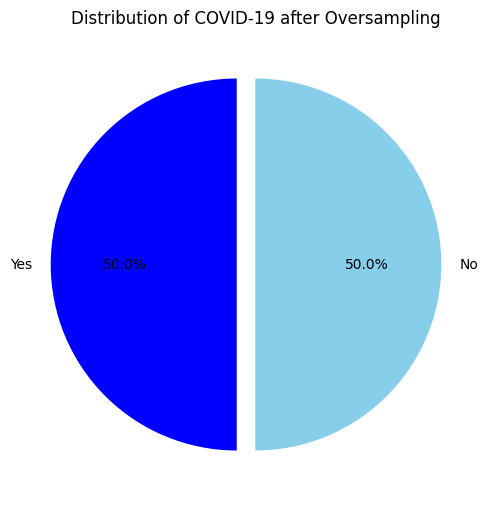

In [81]:
value_counts = df_train_resampled['COVID-19'].value_counts()

plt.figure(figsize=(6,8))
plt.pie(value_counts,
        labels=labels_to_use,
        explode=(.1, 0),
        colors=['blue', 'skyblue'],
        autopct="%1.1f%%",
        startangle=90)
plt.title('Distribution of COVID-19 after Oversampling')
plt.show()

After applying SMOTE to oversample the data, the classes in the training data are now balanced. Consequently, we have two sets of training data: one before applying SMOTE and one after applying SMOTE. The training model will be trained on both sets of data, and the results will be compared.

# Training Model

### Model with data train before applying SMOTE

In [82]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [83]:
# SVM Model
svm_model = SVC(probability=True)
svm_model.fit(X_train, Y_train)

y_pred_svm = svm_model.predict(X_test)

In [84]:
# Accuracy on training set
svm_model.score(X_train, Y_train)

0.9815950920245399

In [85]:
# Accuracy on test set
svm_model.score(X_test, Y_test)

0.9823399558498896

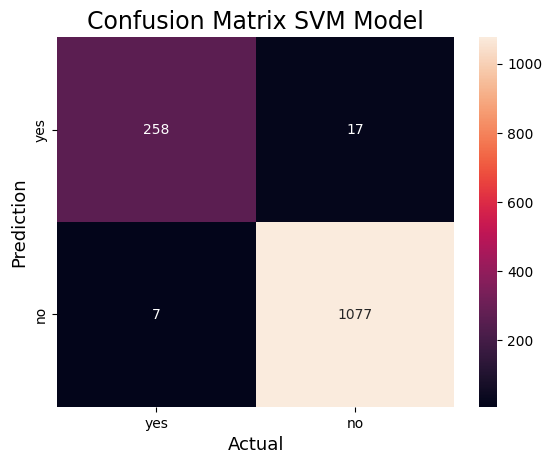

In [86]:
cm_svm=confusion_matrix(Y_test, y_pred_svm)
sns.heatmap(cm_svm,
            annot=True,
            fmt='g',
            xticklabels=['yes','no'],
            yticklabels=['yes','no'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix SVM Model',fontsize=17)
plt.show()

In [87]:
# Decision Tree Model
dcs_model = DecisionTreeClassifier()
dcs_model.fit(X_train, Y_train)

y_pred_dcs = dcs_model.predict(X_test)

In [88]:
# Accuracy on training set
dcs_model.score(X_train, Y_train)

0.981840490797546

In [89]:
# Accuracy on test set
dcs_model.score(X_test, Y_test)

0.9852832965415746

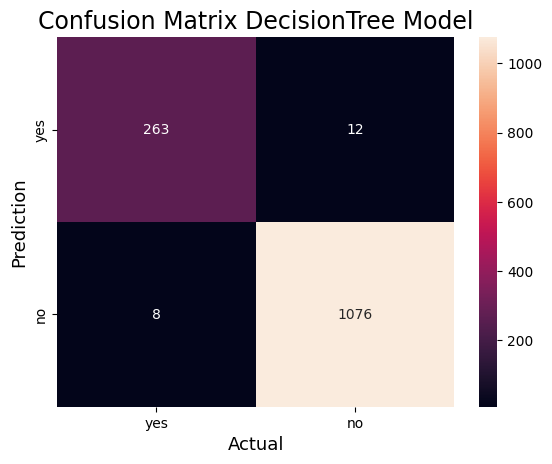

In [90]:
cm_dcs=confusion_matrix(Y_test, y_pred_dcs)
sns.heatmap(cm_dcs,
            annot=True,
            fmt='g',
            xticklabels=['yes','no'],
            yticklabels=['yes','no'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix DecisionTree Model',fontsize=17)
plt.show()

In [91]:
# Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train)

y_pred_logistic = logistic_model.predict(X_test)

In [92]:
# Accuracy on training set
logistic_model.score(X_train, Y_train)

0.969079754601227

In [93]:
# Accuracy on test set
logistic_model.score(X_test, Y_test)

0.9624724061810155

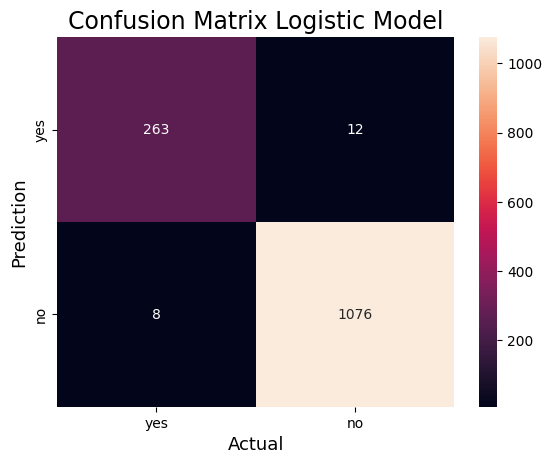

In [94]:
cm_logistic=confusion_matrix(Y_test, y_pred_dcs)
sns.heatmap(cm_logistic,
            annot=True,
            fmt='g',
            xticklabels=['yes','no'],
            yticklabels=['yes','no'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix Logistic Model',fontsize=17)
plt.show()

### Model with data train after applying SMOTE

In [95]:
Y_resampled= df_train_resampled['COVID-19']
X_resampled = df_train_resampled.drop(['COVID-19'], axis = 1)

In [96]:
# SVM Model resample data
svm_model_re = SVC()
svm_model_re.fit(X_resampled, Y_resampled)

y_pred_svm_re = svm_model_re.predict(X_test)

In [97]:
# Accuracy on training set
svm_model_re.score(X_resampled, Y_resampled)

0.9871173082752349

In [98]:
# Accuracy on test set
svm_model_re.score(X_test, Y_test)

0.986019131714496

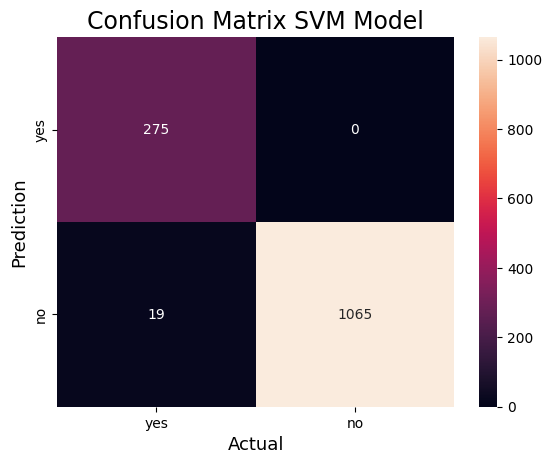

In [99]:
cm_svm_re=confusion_matrix(Y_test, y_pred_svm_re)
sns.heatmap(cm_svm_re,
            annot=True,
            fmt='g',
            xticklabels=['yes','no'],
            yticklabels=['yes','no'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix SVM Model',fontsize=17)
plt.show()

In [100]:
# Decision Tree Model
dcs_model_re = DecisionTreeClassifier()
dcs_model_re.fit(X_resampled, Y_resampled)

y_pred_dcs_re = dcs_model_re.predict(X_test)

In [101]:
# Accuracy on training set
dcs_model_re.score(X_resampled, Y_resampled)

0.9871173082752349

In [102]:
# Accuracy on test set
dcs_model_re.score(X_test, Y_test)

0.986019131714496

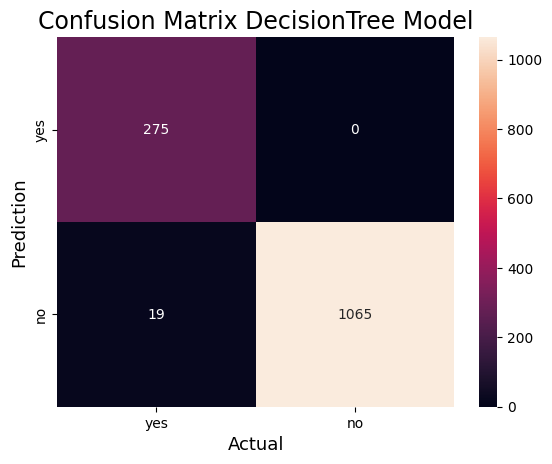

In [103]:
cm_dcs_re=confusion_matrix(Y_test, y_pred_dcs_re)
sns.heatmap(cm_dcs_re,
            annot=True,
            fmt='g',
            xticklabels=['yes','no'],
            yticklabels=['yes','no'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix DecisionTree Model',fontsize=17)
plt.show()

In [104]:
# Logistic Regression Model
logistic_model_re= LogisticRegression()
logistic_model_re.fit(X_resampled, Y_resampled)

y_pred_logistic_re = logistic_model_re.predict(X_test)

In [105]:
# Accuracy on training set
logistic_model_re.score(X_resampled, Y_resampled)

0.9618066080630494

In [106]:
# Accuracy on test set
logistic_model_re.score(X_test, Y_test)

0.9514348785871964

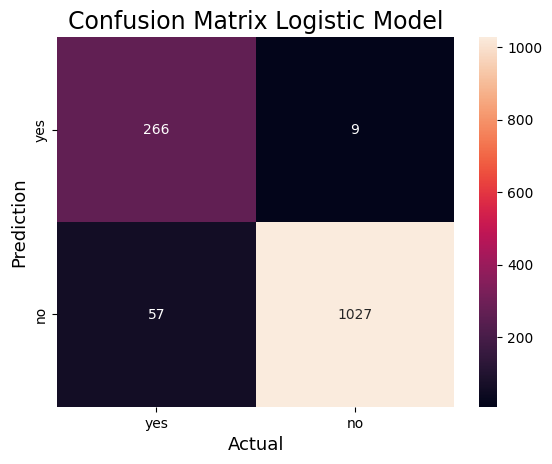

In [107]:
cm_logistic_re=confusion_matrix(Y_test, y_pred_logistic_re)
sns.heatmap(cm_logistic_re,
            annot=True,
            fmt='g',
            xticklabels=['yes','no'],
            yticklabels=['yes','no'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix Logistic Model',fontsize=17)
plt.show()

In [108]:
# Accuracy Scores
svm_train_accuracy = svm_model.score(X_train, Y_train)
svm_test_accuracy = svm_model.score(X_test, Y_test)

decision_tree_train_accuracy = dcs_model.score(X_train, Y_train)
decision_tree_test_accuracy = dcs_model.score(X_test, Y_test)

logistic_train_accuracy = logistic_model.score(X_train, Y_train)
logistic_test_accuracy = logistic_model.score(X_test, Y_test)

svm_train_accuracy_re = svm_model_re.score(X_resampled, Y_resampled)
svm_test_accuracy_re= svm_model_re.score(X_test, Y_test)

decision_tree_train_accuracy_re = dcs_model_re.score(X_resampled, Y_resampled)
decision_tree_test_accuracy_re = dcs_model_re.score(X_test, Y_test)

logistic_train_accuracy_re = logistic_model_re.score(X_resampled, Y_resampled)
logistic_test_accuracy_re = logistic_model_re.score(X_test, Y_test)

In [109]:
from sklearn.metrics import classification_report

# Define a function to extract precision, recall, and F1-score from the classification report
def extract_metrics(report):
    metrics = report['1']
    return metrics['precision'], metrics['recall'], metrics['f1-score']

# Get model classification reports
svm_report = classification_report(Y_test, svm_model.predict(X_test), output_dict=True)
decision_tree_report = classification_report(Y_test, dcs_model.predict(X_test), output_dict=True)
logistic_report = classification_report(Y_test, logistic_model.predict(X_test), output_dict=True)

svm_re_report = classification_report(Y_test, svm_model_re.predict(X_test), output_dict=True)
decision_tree_re_report = classification_report(Y_test, dcs_model_re.predict(X_test), output_dict=True)
logistic_re_report = classification_report(Y_test, logistic_model_re.predict(X_test), output_dict=True)

# Extract metrics
svm_metrics = extract_metrics(svm_report)
decision_tree_metrics = extract_metrics(decision_tree_report)
logistic_metrics = extract_metrics(logistic_report)

svm_re_metrics = extract_metrics(svm_re_report)
decision_tree_re_metrics = extract_metrics(decision_tree_re_report)
logistic_re_metrics = extract_metrics(logistic_re_report)

# Create a DataFrame
results = pd.DataFrame({
    'Model': [
        'SVM', 'Decision Tree', 'Logistic Regression',
        'SVM Data Oversampling', 'Decision Tree Data Oversampling', 'Logistic Regression Data Oversampling'
    ],
    'Training Accuracy': [
        svm_train_accuracy, decision_tree_train_accuracy, logistic_train_accuracy,
        svm_train_accuracy_re, decision_tree_train_accuracy_re, logistic_train_accuracy_re
    ],
    'Test Accuracy': [
        svm_test_accuracy, decision_tree_test_accuracy, logistic_test_accuracy,
        svm_test_accuracy_re, decision_tree_test_accuracy_re, logistic_test_accuracy_re
    ],
    'Precision': [
        svm_metrics[0], decision_tree_metrics[0], logistic_metrics[0],
        svm_re_metrics[0], decision_tree_re_metrics[0], logistic_re_metrics[0]
    ],
    'Recall': [
        svm_metrics[1], decision_tree_metrics[1], logistic_metrics[1],
        svm_re_metrics[1], decision_tree_re_metrics[1], logistic_re_metrics[1]
    ],
    'F1-Score': [
        svm_metrics[2], decision_tree_metrics[2], logistic_metrics[2],
        svm_re_metrics[2], decision_tree_re_metrics[2], logistic_re_metrics[2]
    ]
})

print(results)


                                   Model  Training Accuracy  Test Accuracy  \
0                                    SVM           0.981595       0.982340   
1                          Decision Tree           0.981840       0.985283   
2                    Logistic Regression           0.969080       0.962472   
3                  SVM Data Oversampling           0.987117       0.986019   
4        Decision Tree Data Oversampling           0.987117       0.986019   
5  Logistic Regression Data Oversampling           0.961807       0.951435   

   Precision    Recall  F1-Score  
0   0.984461  0.993542  0.988981  
1   0.988971  0.992620  0.990792  
2   0.967421  0.986162  0.976702  
3   1.000000  0.982472  0.991159  
4   1.000000  0.982472  0.991159  
5   0.991313  0.947417  0.968868  


All the models perform really well, both when they're being trained and when they're being tested. This suggests that the models are really good at spotting patterns in the data. Since the differences in accuracy between the models aren't very big, it's hard to say for sure that one model is better than the others. So, we're going to use a method called Ensemble to combine the different models. This is because each model has its own strengths and weaknesses, and by putting them together, we can make the most of what each model is good at.
Furthermore, many studies have shown that ensemble models can effectively address an imbalanced data class. If you're interested in learning more about this, you can check out these journals:
* [Application of Ensemble Method to Improve Classification algorithm performance on imbalanced dataset](https://www.researchgate.net/publication/330414197_PENERAPAN_METODE_ENSEMBLE_UNTUK_MENINGKATKAN_KINERJA_ALGORITME_KLASIFIKASI_PADA_IMBALANCED_DATASET#:~:text=Hal%20ini%20menunjukkan%20bahwa%20metode,kinerja%20algoritme%20pada%20imbalanced%20dataset.)
* [Solving the Class Imbalance Problem Using Ensemble Algorithm](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-022-01821-w)

# Ensemble Model

In [110]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble model using Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('decision_tree', dcs_model),
        ('logistic_regression', logistic_model)
    ],
    voting='soft'  #'hard' for majority voting, 'soft' for averaging probabilities
)

In [111]:
# Train the ensemble model
ensemble_model.fit(X_train, Y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('decision_tree', DecisionTreeClassifier()),
                             ('logistic_regression', LogisticRegression())],
                 voting='soft')

In [112]:
# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

print(metrics_df)

      Metric     Score
0   Accuracy  0.982340
1  Precision  0.984461
2     Recall  0.993542
3   F1 Score  0.988981


In [114]:
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the custom wrapper
class TrainedModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = None

    def fit(self, X, y=None):
        self.model.fit(X, y)
        self.classes_ = self.model.classes_
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Create wrapped models
svm_wrapper = TrainedModelWrapper(svm_model)
decision_tree_wrapper = TrainedModelWrapper(dcs_model)
logistic_wrapper = TrainedModelWrapper(logistic_model)

In [115]:
# Define the base models and meta-model
base_models = [
    ('svm', svm_wrapper),
    ('decision_tree', decision_tree_wrapper),
    ('logistic', logistic_wrapper)
]
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True
)

In [116]:
# Train the stacking model
stacking_clf.fit(X_train, Y_train)

# Make predictions
y_pred_stack = stacking_clf.predict(X_test)

In [117]:
# Calculate metrics
accuracy_stack = accuracy_score(Y_test, y_pred_stack)
precision_stack= precision_score(Y_test, y_pred_stack, average='binary')
recall_stack = recall_score(Y_test, y_pred_stack, average='binary')
f1_stack = f1_score(Y_test, y_pred_stack, average='binary')

# Create a DataFrame to display the results
metrics_df_stack = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy_stack, precision_stack, recall_stack, f1_stack]
})

print(metrics_df_stack)

      Metric     Score
0   Accuracy  0.981604
1  Precision  0.983562
2     Recall  0.993542
3   F1 Score  0.988527


In [118]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assume you have models already trained and y_pred_stack, y_pred are predictions from stacked models

# Define a function to extract precision, recall, and F1-score from the classification report
def extract_metrics(report):
    metrics = report['1']
    return metrics['precision'], metrics['recall'], metrics['f1-score']

# Get classification reports for each model
svm_report = classification_report(Y_test, svm_model.predict(X_test), output_dict=True)
decision_tree_report = classification_report(Y_test, dcs_model.predict(X_test), output_dict=True)
logistic_report = classification_report(Y_test, logistic_model.predict(X_test), output_dict=True)

svm_re_report = classification_report(Y_test, svm_model_re.predict(X_test), output_dict=True)
decision_tree_re_report = classification_report(Y_test, dcs_model_re.predict(X_test), output_dict=True)
logistic_re_report = classification_report(Y_test, logistic_model_re.predict(X_test), output_dict=True)

# Extract metrics for each model
svm_metrics = extract_metrics(svm_report)
decision_tree_metrics = extract_metrics(decision_tree_report)
logistic_metrics = extract_metrics(logistic_report)

svm_re_metrics = extract_metrics(svm_re_report)
decision_tree_re_metrics = extract_metrics(decision_tree_re_report)
logistic_re_metrics = extract_metrics(logistic_re_report)

# Calculate metrics for ensemble and stacked models
accuracy_stack = accuracy_score(Y_test, y_pred_stack)
precision_stack = precision_score(Y_test, y_pred_stack, average='binary')
recall_stack = recall_score(Y_test, y_pred_stack, average='binary')
f1_stack = f1_score(Y_test, y_pred_stack, average='binary')

accuracy_ensemble = accuracy_score(Y_test, y_pred)
precision_ensemble = precision_score(Y_test, y_pred, average='binary')
recall_ensemble = recall_score(Y_test, y_pred, average='binary')
f1_ensemble = f1_score(Y_test, y_pred, average='binary')

# Calculate training predictions for stacked and ensemble models
y_train_pred_stack = stacking_clf.predict(X_train)
y_train_pred_voting = ensemble_model.predict(X_train)

# Calculate training accuracy for stacked and ensemble models
train_accuracy_stack = accuracy_score(Y_train, y_train_pred_stack)
train_accuracy_ensemble = accuracy_score(Y_train, y_train_pred_voting)

# Create a DataFrame with all results
results = pd.DataFrame({
    'Model': [
        'SVM', 'Decision Tree', 'Logistic Regression',
        'SVM Data Oversampling', 'Decision Tree Data Oversampling', 'Logistic Regression Data Oversampling',
        'Stacking Ensemble', 'Voting Ensemble'
    ],
    'Training Accuracy': [
        svm_train_accuracy, decision_tree_train_accuracy, logistic_train_accuracy,
        svm_train_accuracy_re, decision_tree_train_accuracy_re, logistic_train_accuracy_re,
        train_accuracy_stack, train_accuracy_ensemble
    ],
    'Test Accuracy': [
        svm_test_accuracy, decision_tree_test_accuracy, logistic_test_accuracy,
        svm_test_accuracy_re, decision_tree_test_accuracy_re, logistic_test_accuracy_re,
        accuracy_stack, accuracy_ensemble
    ],
    'Precision': [
        svm_metrics[0], decision_tree_metrics[0], logistic_metrics[0],
        svm_re_metrics[0], decision_tree_re_metrics[0], logistic_re_metrics[0],
        precision_stack, precision_ensemble
    ],
    'Recall': [
        svm_metrics[1], decision_tree_metrics[1], logistic_metrics[1],
        svm_re_metrics[1], decision_tree_re_metrics[1], logistic_re_metrics[1],
        recall_stack, recall_ensemble
    ],
    'F1-Score': [
        svm_metrics[2], decision_tree_metrics[2], logistic_metrics[2],
        svm_re_metrics[2], decision_tree_re_metrics[2], logistic_re_metrics[2],
        f1_stack, f1_ensemble
    ]
})

print(results)


                                   Model  Training Accuracy  Test Accuracy  \
0                                    SVM           0.981595       0.982340   
1                          Decision Tree           0.981840       0.985283   
2                    Logistic Regression           0.969080       0.962472   
3                  SVM Data Oversampling           0.987117       0.986019   
4        Decision Tree Data Oversampling           0.987117       0.986019   
5  Logistic Regression Data Oversampling           0.961807       0.951435   
6                      Stacking Ensemble           0.981595       0.981604   
7                        Voting Ensemble           0.981595       0.982340   

   Precision    Recall  F1-Score  
0   0.984461  0.993542  0.988981  
1   0.988971  0.992620  0.990792  
2   0.967421  0.986162  0.976702  
3   1.000000  0.982472  0.991159  
4   1.000000  0.982472  0.991159  
5   0.991313  0.947417  0.968868  
6   0.983562  0.993542  0.988527  
7   0.984461  0.9

# Conclusion

* Models that use oversampling techniques (SVM Data Oversampling, Decision Tree Data oversampling, Logistic Regression Data Oversammplings) tend to have higher accuracy than models without oversampling. However, the differences are slight. This indicates that data oversampling effectively addresses the problem of class imbalances in the datasets.
* The ensemble models (Stacking Ensemble and Voting Ensemble) perform well, especially regarding F1 scores. It shows that combining several models can improve overall performance.
* The Decision Tree model (either with or without oversampling) consistently shows good performance. This indicates that the data structure used may match the decision tree approach.
* For most models, the difference between training and test accuracy is relatively minor, indicating that the models are not overfitting.

The evaluation results show that:

* Oversampling is an effective technique to improve model performance on unbalanced datasets.
* Ensemble models such as Stacking and Voting can deliver good results.
* The Decision Tree is a powerful algorithm for this data set.